## Черновик

## 1. Импорт библиотек и загрузка данных

In [1]:
import pandas as pd
import numpy as np
import os
import json
import warnings
import missingno as msno
import seaborn as sns
from matplotlib import pyplot as plt
from phik import phik_matrix
from phik.report import plot_correlation_matrix
import optuna
from catboost import CatBoostClassifier
import shap
from scipy.stats import kstest
from scipy.stats import zscore
from scipy.stats import ks_2samp, chi2_contingency, chisquare
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from optuna.samplers import RandomSampler
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import precision_recall_curve, auc

In [2]:
warnings.filterwarnings("ignore")
optuna.logging.set_verbosity(optuna.logging.ERROR)
pd.set_option('display.max_columns', None)

DATA_PATH = ''
RANDOM_STATE = 42

In [3]:
local_df_train_path = os.path.join(DATA_PATH, 'shift_ml_2025_train.csv')
local_df_test_path = os.path.join(DATA_PATH, 'shift_ml_2025_test.csv')
local_submission_path = os.path.join(DATA_PATH, 'submission.csv')
local_catboost_param_path = os.path.join(DATA_PATH, 'catboost_best_params.json')

In [4]:
df_train = pd.read_csv(local_df_train_path)
df_test = pd.read_csv(local_df_test_path)
submission = pd.read_csv(local_submission_path)

with open("catboost_best_params.json", "r") as f:
    CATBOOST_PARAMS = json.load(f)

In [5]:
for i,z in zip([df_train,df_test,submission],['df_train','df_test','submission']):
    print(z)
    print()
    print(i.shape)
    print()
    display(i.info())
    display(i.head())
    print(f'ПРОПУСКОВ В {z}: {i.isna().sum().sum()}')
    print(f'ЯВНЫХ ДУБЛИКАТОВ В {z}: {i.duplicated().sum()}')
    print('-------------------------------------------------------------------------------------------------------------')
    print()
    print()

df_train

(1210779, 109)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1210779 entries, 0 to 1210778
Columns: 109 entries, id to тип_предоставления_кредита
dtypes: float64(84), int64(6), object(19)
memory usage: 1006.9+ MB


None

,id,сумма_займа,срок_займа,процентная_ставка,аннуитет,рейтинг,допрейтинг,профессия_заемщика,стаж,владение_жильем,годовой_доход,подтвержден_ли_доход,итоговый_статус_займа,рейтинг_OCR,платежный_график,коэфф_акционных_зачислений_в_остатке,цель_займа,кол_во_субсидий_за_год,индекс_проживания,регион,пдн,пос_стоп_фактор,юридический_статус,кол-во_просрочек_за_два_года,коэфф_невыплаченного_сумм_остатка,коэфф_исходного_платежа,дата_первого_займа,нижний_порог_рейтинга_заемщика,верхний_порог_рейтинга_заемщика,кол-во_заявок_за_полгода,кол-во_месяцев_с_последней_просрочки,кол-во_месяцев_с_последнего_займа,кол-во_открытых_счетов,кол-во_записей_в_общедоступных_документах,оборотный_баланс,коэфф_загрузки_возобновляемого_счета,кол-во_счетов,первоначальный_статус_займа,непогашенная_сумма_из_тела_займов,сумма_выплат_по_просрочкам,пени_за_дефолт,дата_следующей_выплаты,грейд_на_детерминаторе,кол-во_взысканий_за_последний_год,кол-во_месяцев_с_последнего_нарушения,код_политики,тип_займа,совокупный_доход_заемщиков,совокупный_пдн_заемщиков,совокупный_статус_подтверждения_доходов_заемщиков,кол-во_текущих_просроченных_счетов,общая_сумма_взысканий,возвраты_с_учетом_мпл,общая_сумма_на_счетах,кол-во_открытых_счетов_за_полгода,кол-во_текущих_аннуитетных_счетов,кол-во_аннуитетных_счетов_за_год,кол-во_аннуитетных_счетов_за_2_года,кол-во_месяцев_с_посл_аннуитетного_счета,текущий_баланс_по_аннуитетным_счетам,соотношение_сумм_текущего_баланса_к_лимиту_по_аннуитетным_счетам,кол-во_возоб_счетов_за_год,кол-во_возоб_счетов_за_2_года,макс_баланс_по_возоб_счетам,соотношение_баланса_к_лимиту_общее,общий_лимит_по_возоб_счету,кол-во_финансовых_запросов,кол-во_финансовых_операций,кол-во_заявок_на_кредит_за_год,кол-во_открытых_счетов_за_2_года,средний_баланс_текущих_счетов,суммарная_доступная_сумма_займа_по_картам,соотношение_баланса_к_лимиту_по_картам,кол-во_списаний_за_год,сумма_задолженности,кол-во_месяцев_с_первого_аннуитетного_счета,кол-во_месяцев_с_первого_возобновляемого_счета,кол-во_месяцев_с_последнего_возобновляемого_счета,кол-во_месяцев_с_последнего_счета,кол-во_ипотек,кол-во_месяцев_с_последней_карты,кол-во_мес_с_последней_задолженности_по_карте,кол-во_мес_с_последней_заявки,кол-во_мес_с_последней_задолженности_по_возобновляемому_счету,кол-во_счетов_с_просрочкой_4_мес,кол-во_активных_карт,кол-во_активных_возобновляемых_счетов,кол-во_карт_без_нарушений,кол-во_карт,кол-во_аннуитетных_счетов,кол-во_открытых_возобновляемых_счетов,кол-во_возобновляемых_счетов,кол-во_возобновляемых_счетов_с_балансом_более_0,кол-во_счетов_без_нарушений,кол-во_счетов_с_акт_просрочкой_4_мес_обн_2_мес,кол-во_счетов_с_акт_просрочкой_1_мес,кол-во_счетов_с_акт_просрочкой_3_мес_за_2_года,кол-во_счетов_за_посл_год,процент_счетов_без_просрочек,процент_счетов_прев_75_лимита,кол-во_публ_банкротств,кол-во_залогов,кредитный_лимит,кредитный_баланс_без_ипотеки,лимит_по_картам,лимит_по_аннуитетным_счетам,кредитный_баланс_по_возоб_счетам,особая_ситуация,тип_предоставления_кредита
0,68355089,1235000.0,3 года,11.99,41014.0,В,В1,инженер,10+ лет,ИПОТЕКА,1300000.0,Не подтвержден,0,4,n,0.899168,мелкий_бизнес,0,577.0,Новгородская область,16.06,Нет,Нет,1.0,1.345312e+06,0.767016,12-1999,715.0,719.0,4.0,6.0,NaN,22.0,0.0,21470.0,19.2,38.0,а,0.0,0.0,False,NaN,5,0.0,NaN,1.0,Индивидуальный,NaN,NaN,NaN,0.0,0.0,12213,10219800.0,1.0,1.0,0.0,1.0,19.0,900250.0,73.0,2.0,3.0,6472.0,29.0,5590000.0,0.0,0.0,6.0,4.0,486650.0,2891500.0,27.1,0.0,0.0,113.0,192.0,2.0,2.0,4.0,2.0,NaN,0.0,6.0,0.0,5.0,5.0,13.0,17.0,6.0,20.0,27.0,5.0,22.0,0.0,0.0,0.0,2.0,97.4,7.7,0.0,0.0,15700850.0,1973750.0,3965000.0,1233350.0,NaN,Нет,Наличные
1,68341763,1000000.0,5 лет,10.78,21633.0,Б,Б4,водитель грузовика,10+ лет,ИПОТЕКА,1260000.0,Не подтвержден,0,2,n,0.489891,улучшение_жилищных_условий,0,605.0,Республика Татарстан,10.78,Нет,Нет,0.0,1.345312e+06,0.229990,8-2000,695.0,699.0,0.0,NaN,NaN,6.0,0.0,7869.0,56.2,18.0,а,0.0,0.0,NaN,NaN,1,0.0,NaN,1.0,Совместный,3550000.0,13.85,Не подтвержден,0.0,0.0,36245,9484950.0,0.0,1.0,0.0,4.0,19.0,541350.0,73.0,0.0,2.0,2

ПРОПУСКОВ В df_train: 23096083
ЯВНЫХ ДУБЛИКАТОВ В df_train: 0
-------------------------------------------------------------------------------------------------------------


df_test

(134531, 108)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 134531 entries, 0 to 134530
Columns: 108 entries, id to тип_предоставления_кредита
dtypes: float64(85), int64(5), object(18)
memory usage: 110.9+ MB


None

,id,сумма_займа,срок_займа,процентная_ставка,аннуитет,рейтинг,допрейтинг,профессия_заемщика,стаж,владение_жильем,годовой_доход,подтвержден_ли_доход,рейтинг_OCR,платежный_график,коэфф_акционных_зачислений_в_остатке,цель_займа,кол_во_субсидий_за_год,индекс_проживания,регион,пдн,пос_стоп_фактор,юридический_статус,кол-во_просрочек_за_два_года,коэфф_невыплаченного_сумм_остатка,коэфф_исходного_платежа,дата_первого_займа,нижний_порог_рейтинга_заемщика,верхний_порог_рейтинга_заемщика,кол-во_заявок_за_полгода,кол-во_месяцев_с_последней_просрочки,кол-во_месяцев_с_последнего_займа,кол-во_открытых_счетов,кол-во_записей_в_общедоступных_документах,оборотный_баланс,коэфф_загрузки_возобновляемого_счета,кол-во_счетов,первоначальный_статус_займа,непогашенная_сумма_из_тела_займов,сумма_выплат_по_просрочкам,пени_за_дефолт,дата_следующей_выплаты,грейд_на_детерминаторе,кол-во_взысканий_за_последний_год,кол-во_месяцев_с_последнего_нарушения,код_политики,тип_займа,совокупный_доход_заемщиков,совокупный_пдн_заемщиков,совокупный_статус_подтверждения_доходов_заемщиков,кол-во_текущих_просроченных_счетов,общая_сумма_взысканий,возвраты_с_учетом_мпл,общая_сумма_на_счетах,кол-во_открытых_счетов_за_полгода,кол-во_текущих_аннуитетных_счетов,кол-во_аннуитетных_счетов_за_год,кол-во_аннуитетных_счетов_за_2_года,кол-во_месяцев_с_посл_аннуитетного_счета,текущий_баланс_по_аннуитетным_счетам,соотношение_сумм_текущего_баланса_к_лимиту_по_аннуитетным_счетам,кол-во_возоб_счетов_за_год,кол-во_возоб_счетов_за_2_года,макс_баланс_по_возоб_счетам,соотношение_баланса_к_лимиту_общее,общий_лимит_по_возоб_счету,кол-во_финансовых_запросов,кол-во_финансовых_операций,кол-во_заявок_на_кредит_за_год,кол-во_открытых_счетов_за_2_года,средний_баланс_текущих_счетов,суммарная_доступная_сумма_займа_по_картам,соотношение_баланса_к_лимиту_по_картам,кол-во_списаний_за_год,сумма_задолженности,кол-во_месяцев_с_первого_аннуитетного_счета,кол-во_месяцев_с_первого_возобновляемого_счета,кол-во_месяцев_с_последнего_возобновляемого_счета,кол-во_месяцев_с_последнего_счета,кол-во_ипотек,кол-во_месяцев_с_последней_карты,кол-во_мес_с_последней_задолженности_по_карте,кол-во_мес_с_последней_заявки,кол-во_мес_с_последней_задолженности_по_возобновляемому_счету,кол-во_счетов_с_просрочкой_4_мес,кол-во_активных_карт,кол-во_активных_возобновляемых_счетов,кол-во_карт_без_нарушений,кол-во_карт,кол-во_аннуитетных_счетов,кол-во_открытых_возобновляемых_счетов,кол-во_возобновляемых_счетов,кол-во_возобновляемых_счетов_с_балансом_более_0,кол-во_счетов_без_нарушений,кол-во_счетов_с_акт_просрочкой_4_мес_обн_2_мес,кол-во_счетов_с_акт_просрочкой_1_мес,кол-во_счетов_с_акт_просрочкой_3_мес_за_2_года,кол-во_счетов_за_посл_год,процент_счетов_без_просрочек,процент_счетов_прев_75_лимита,кол-во_публ_банкротств,кол-во_залогов,кредитный_лимит,кредитный_баланс_без_ипотеки,лимит_по_картам,лимит_по_аннуитетным_счетам,кредитный_баланс_по_возоб_счетам,особая_ситуация,тип_предоставления_кредита
0,85540387,450000.0,3 года,9.49,14413.0,Б,Б2,обслуживание клиентов,10+ лет,ИПОТЕКА,840000.0,Не подтвержден,4,n,0.458947,консолидация_долга,0,601.0,Республика Татарстан,19.09,Нет,Да,0.0,1.345312e+06,0.812613,6-1995,740.0,744.0,0.0,NaN,NaN,11.0,0.0,7735.0,34.1,20.0,а,0.0,0.0,NaN,NaN,1,0.0,NaN,1.0,Индивидуальный,NaN,NaN,NaN,0.0,0.0,92843,3111700.0,0.0,2.0,1.0,2.0,10.0,793850.0,78.0,0.0,1.0,2594.0,55.0,1135000.0,1.0,1.0,2.0,3.0,282900.0,395700.0,45.4,0.0,0.0,112.0,253.0,17.0,10.0,2.0,17.0,NaN,10.0,NaN,0.0,3.0,5.0,4.0,6.0,7.0,8.0,11.0,5.0,11.0,0.0,0.0,0.0,1.0,100.0,75.0,0.0,0.0,4282850.0,1180600.0,725000.0,1022000.0,NaN,Нет,Наличные
1,28112500,400000.0,3 года,6.03,12174.5,А,А1,помощник по правовым вопросам,5 лет,АРЕНДА,1520000.0,Не подтвержден,4,n,0.006964,консолидация_долга,0,112.0,Новосибирская область,20.42,Нет,Нет,0.0,1.345312e+06,0.725167,12-1997,710.0,714.0,0.0,NaN,NaN,14.0,0.0,23650.0,78.6,28.0,б,0.0,0.0,NaN,NaN,1,0.0,NaN,1.0,Индивидуальный,NaN,NaN,NaN,0.0,0.0,43004,2381050.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1505000.0,NaN,NaN,NaN,1.0,18

ПРОПУСКОВ В df_test: 2663443
ЯВНЫХ ДУБЛИКАТОВ В df_test: 0
-------------------------------------------------------------------------------------------------------------


submission

(134531, 2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 134531 entries, 0 to 134530
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   id      134531 non-null  int64  
 1   proba   134531 non-null  float64
dtypes: float64(1), int64(1)
memory usage: 2.1 MB


None

,id,proba
0,85540387,0.093564
1,28112500,0.056402
2,65731570,0.114370
3,65874747,0.465359
4,57893355,0.235636


ПРОПУСКОВ В submission: 0
ЯВНЫХ ДУБЛИКАТОВ В submission: 0
-------------------------------------------------------------------------------------------------------------




Данные загружены и осмотрены.

## 2. EDA

Оценим визуально ситуацию с пропусками.

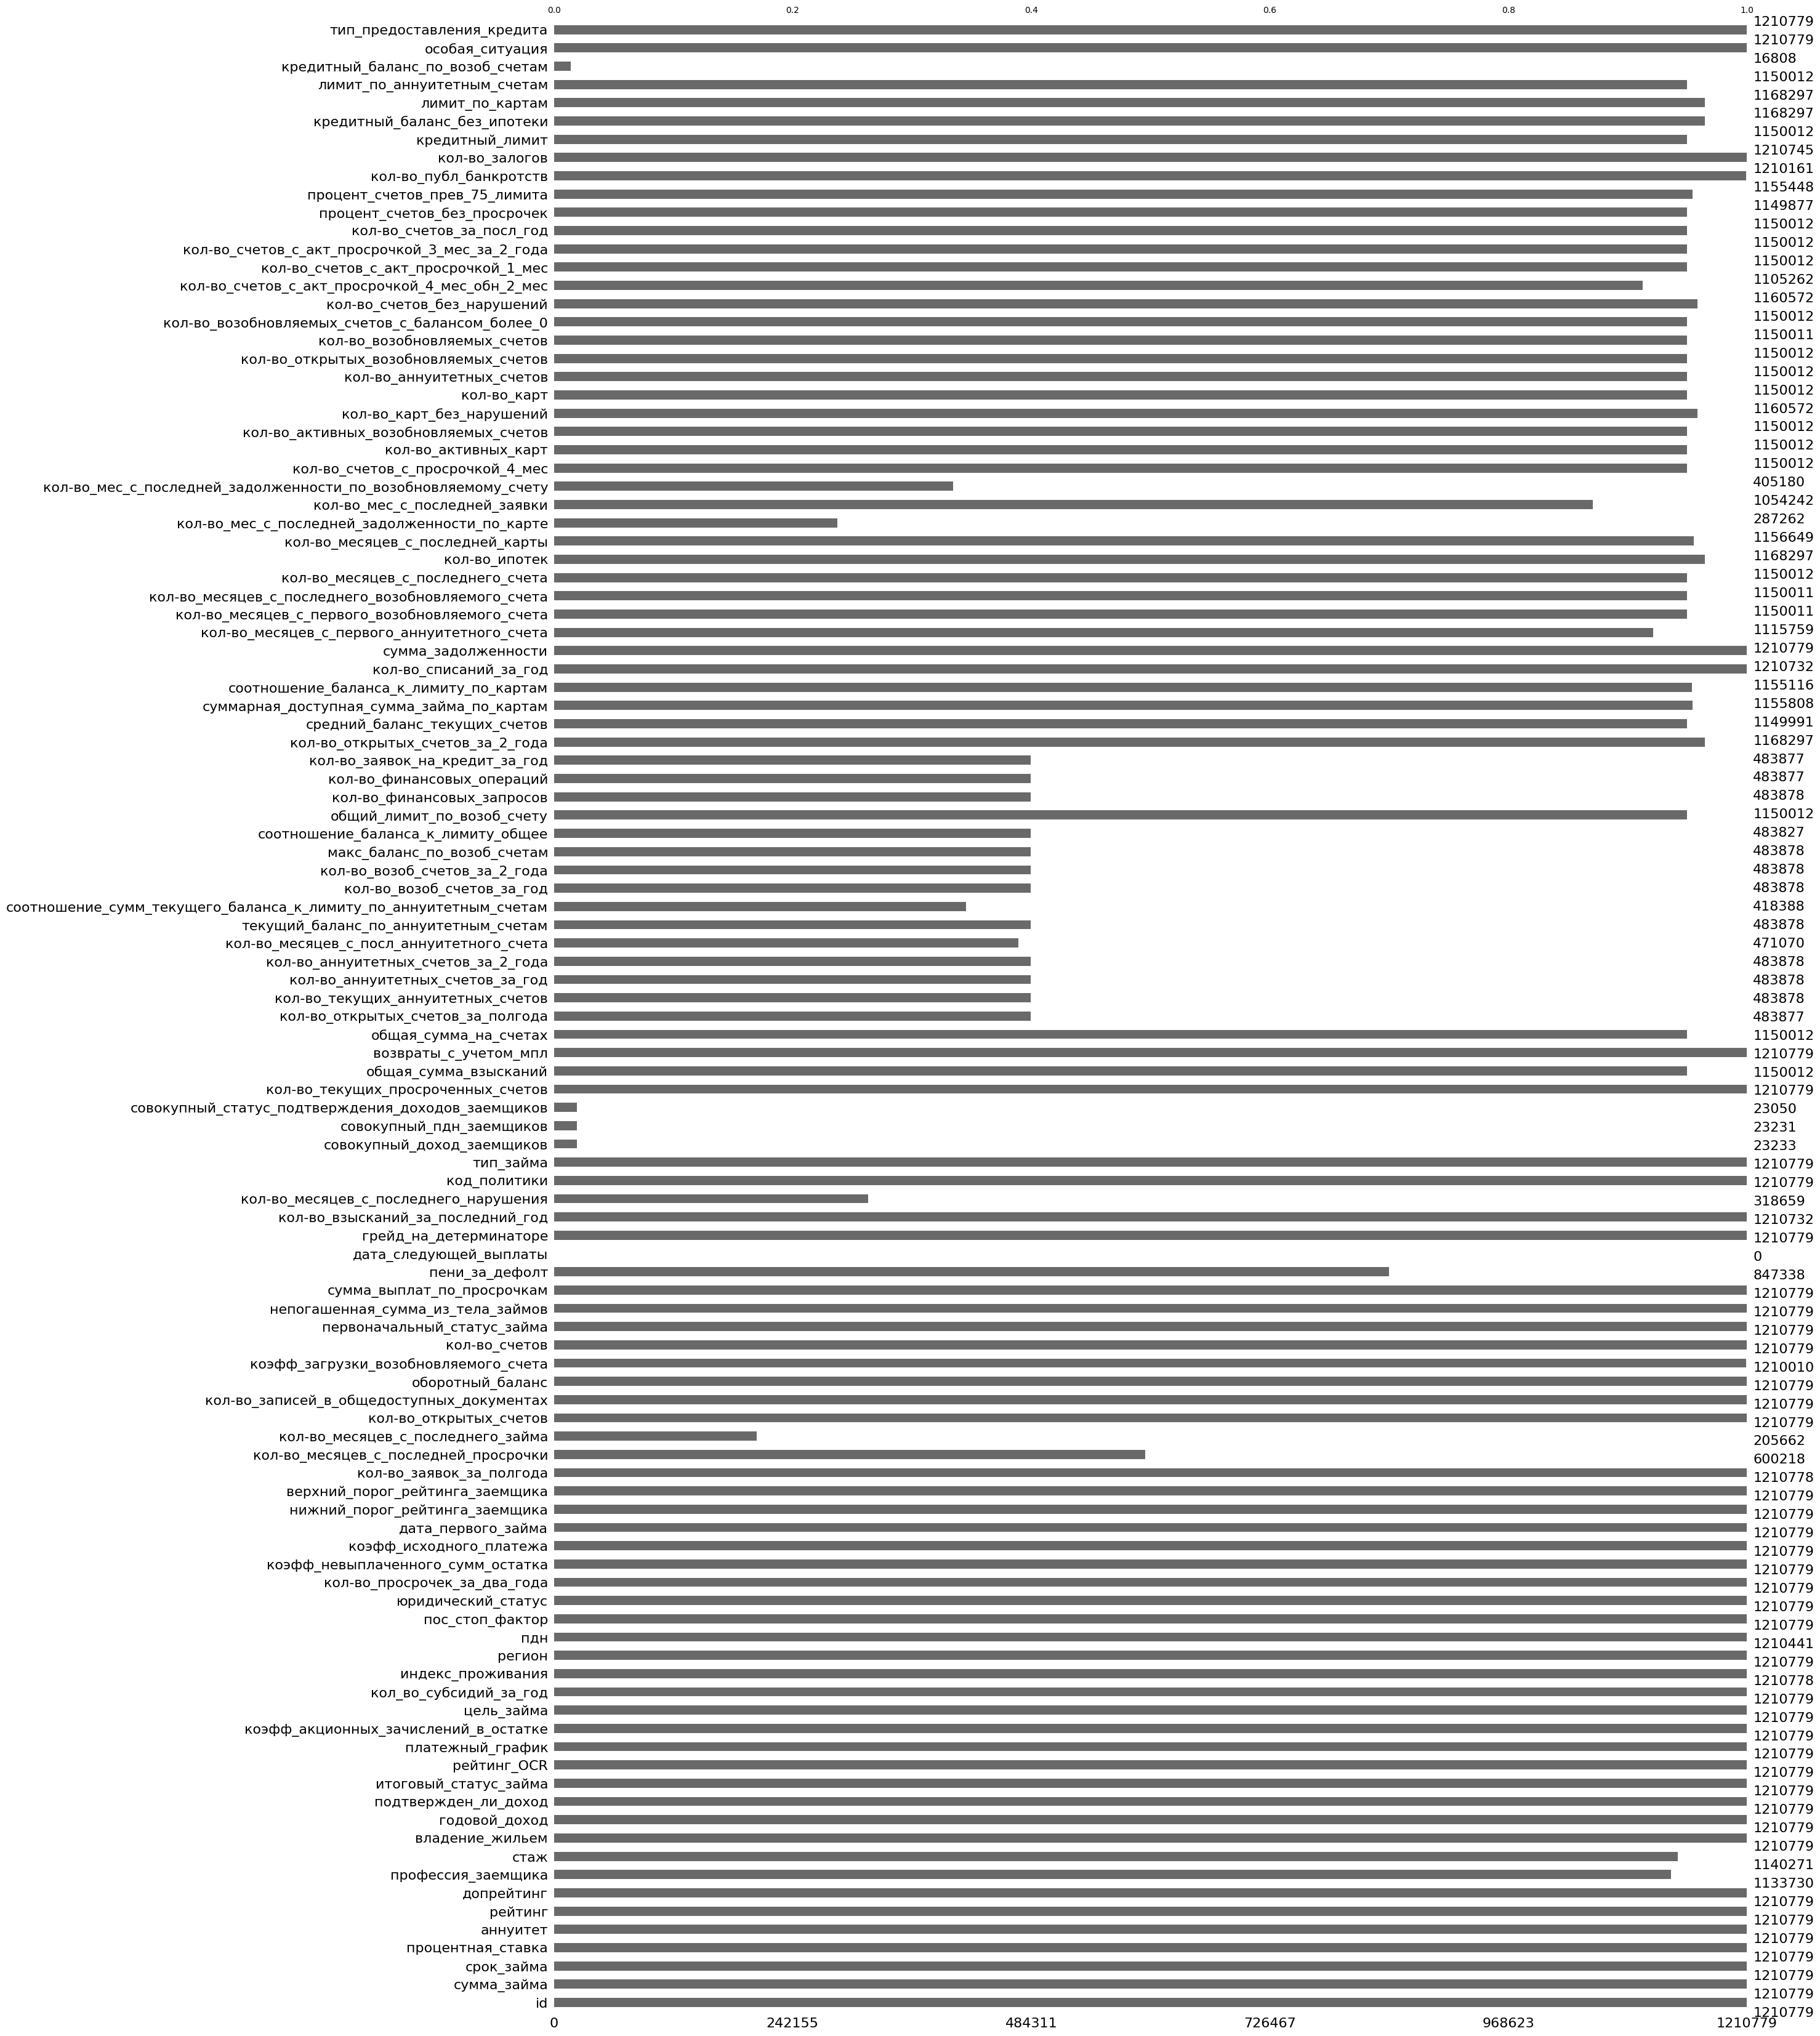

In [6]:
msno.bar(df_train);

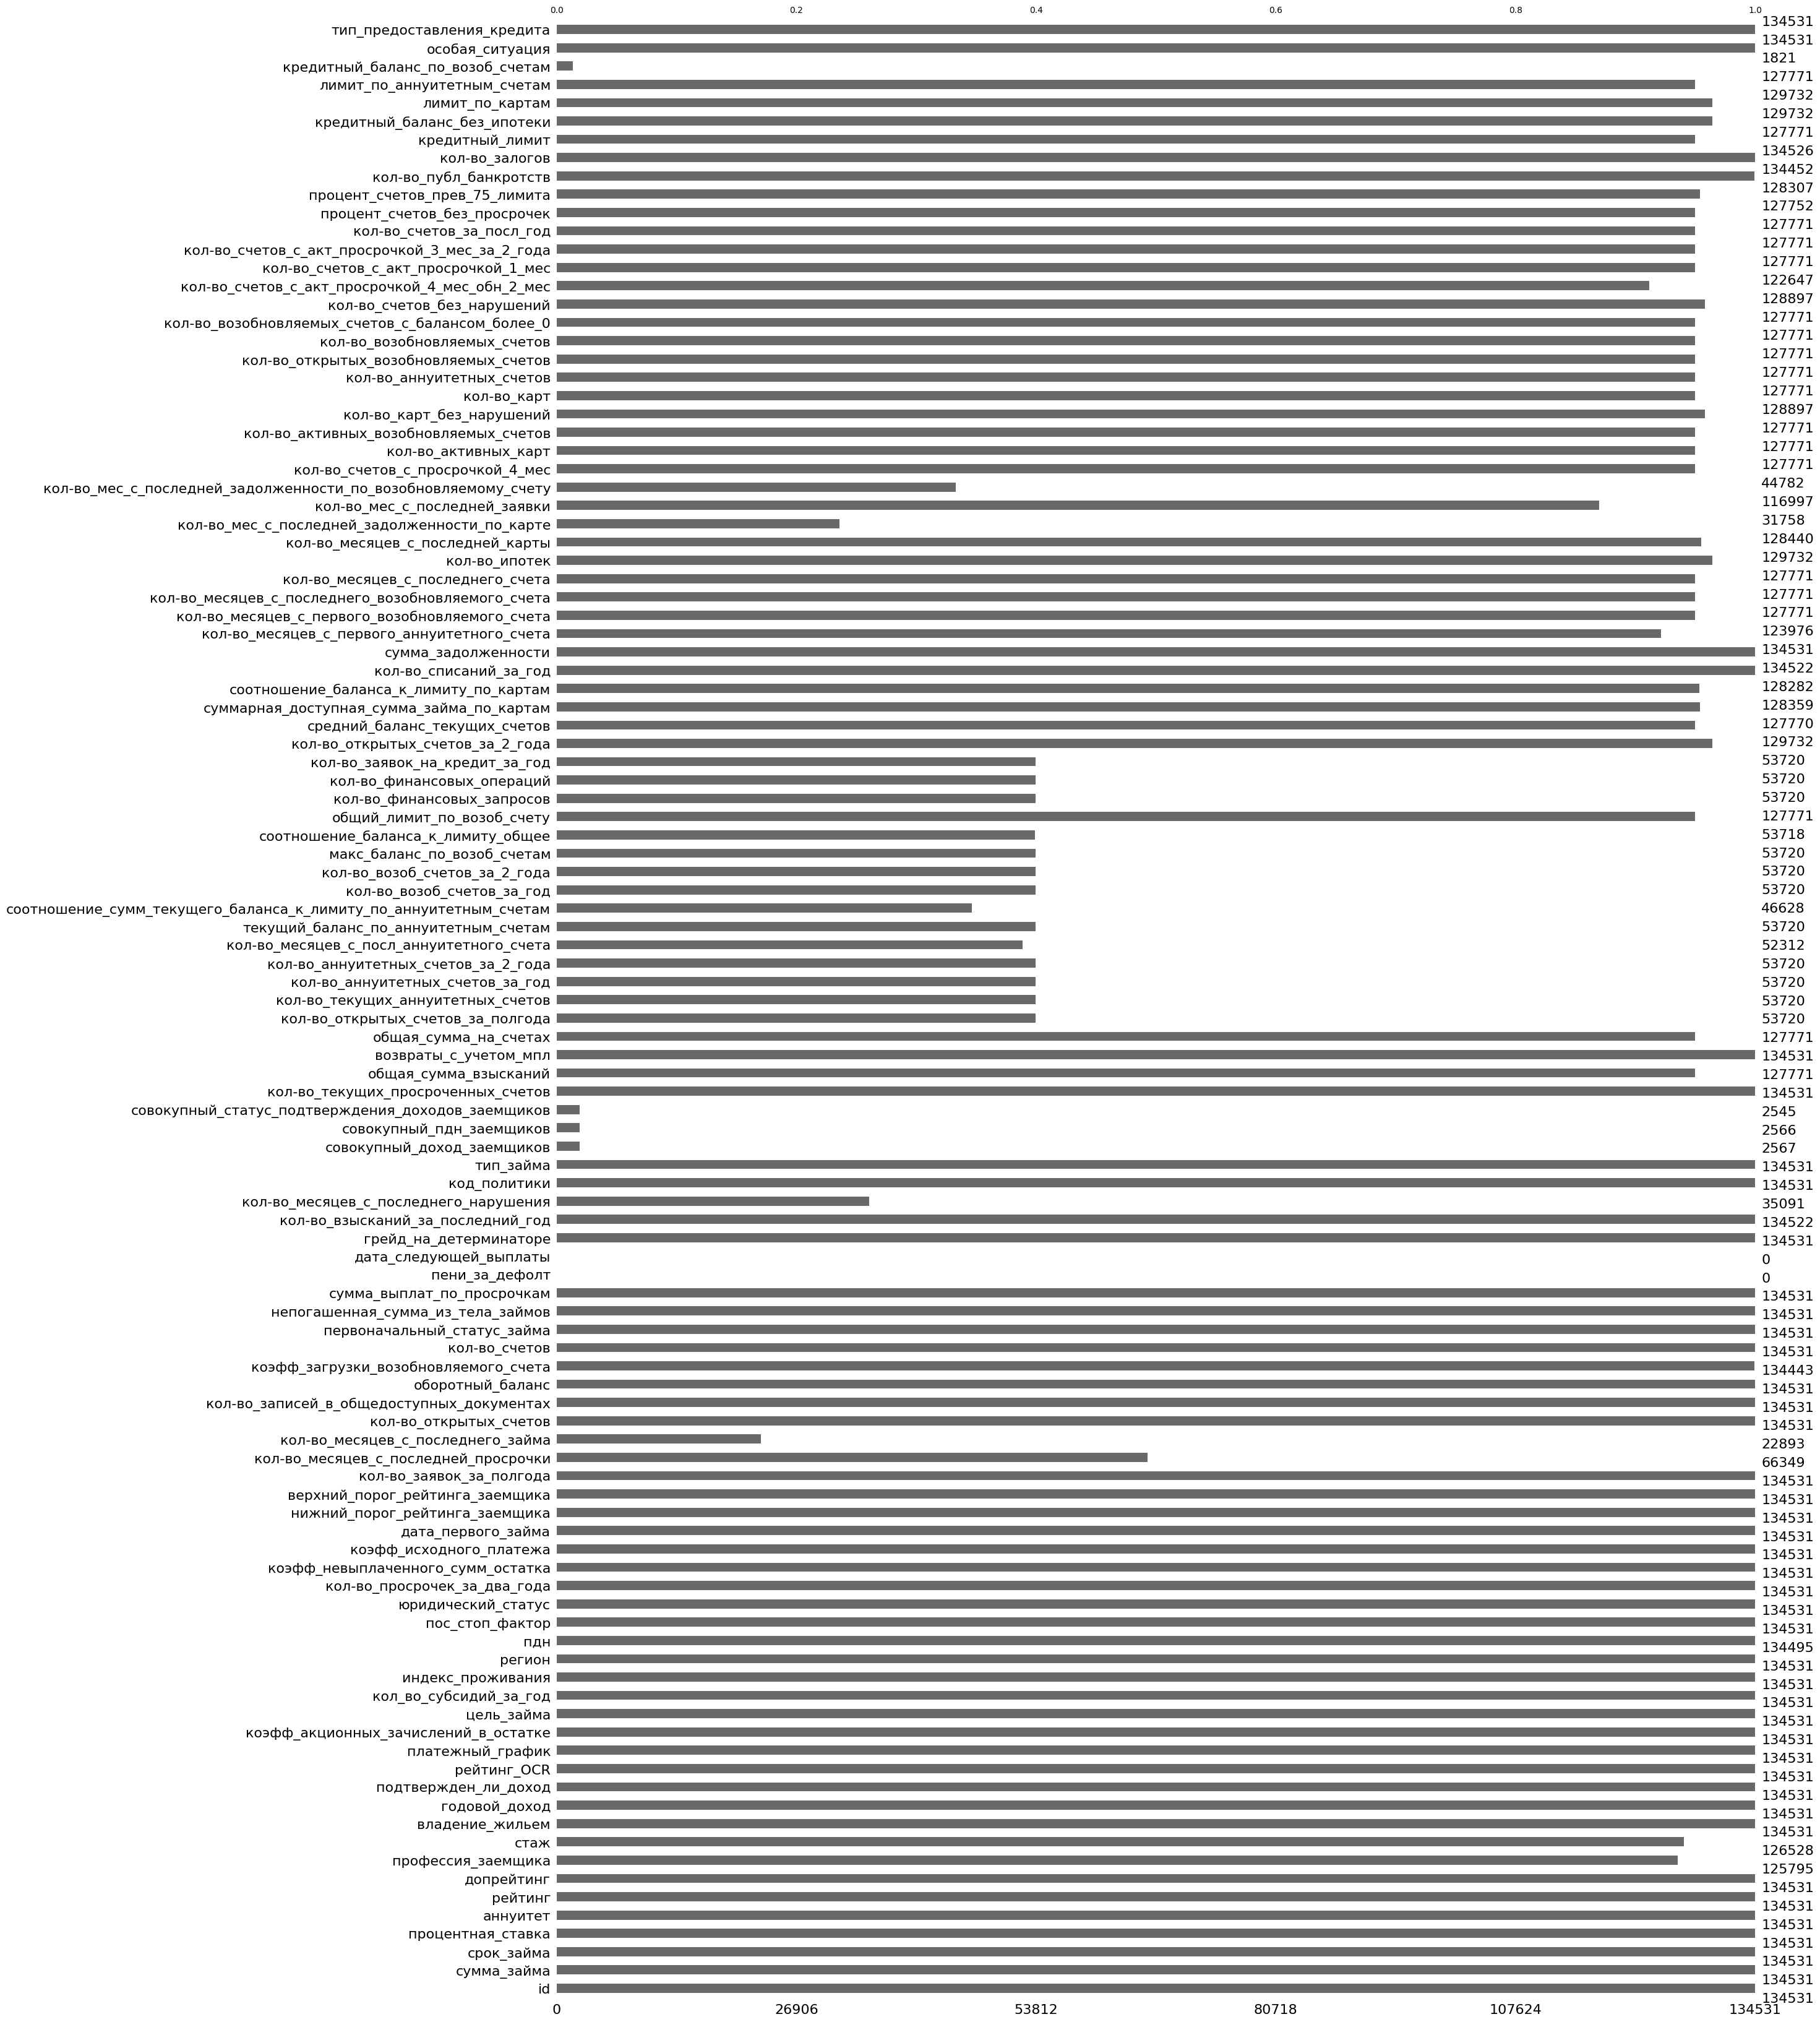

In [7]:
msno.bar(df_test);

Как видно на изображениях, есть признаки , где количество пропусков гораздо выше 50 %. От таких признаков мы далее избавимся.

Оценим, как распределена целевая переменная.

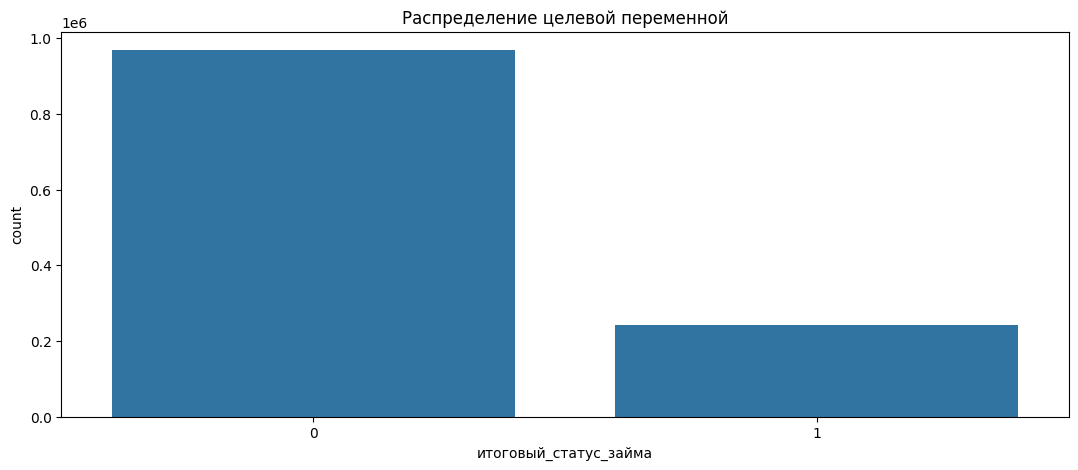

In [8]:
plt.figure(figsize=(13,5));
sns.countplot(data=df_train, x='итоговый_статус_займа');
plt.title(f"Распределение целевой переменной")
plt.show()

In [9]:
df_train['итоговый_статус_займа'].mean()

np.float64(0.19961859265811516)

Имеется явный дисбаланс классов. 80 % составляет нулевой класс, 20 % - единицы.

Учитывая, что в тренировочном датасете у нас 1210779 записей, и 109 признаков, процесс визуализации такого объема данных займет неприлично большое количество времени.

Объявлю функцию для поиска репрезентативного процента выборки на основе теста Колмогорова-Смирнова для численных признаков, и Хи-квадрата для категориальных.

Так же ниже с помощью нее проверим однородность обучающего и тестового датафреймов.

In [10]:
def reprez_sample(
    df: pd.DataFrame | pd.Series,
    y: pd.DataFrame | pd.Series = None,
    frac: list | np.ndarray = None,
    random_state: int = 42,
    alpha: float = 0.05
):
    
    if isinstance(df, pd.DataFrame) and isinstance(y, pd.DataFrame):
        if set(df.columns) != set(y.columns):
            raise ValueError("Оба DataFrame должны содержать одинаковые столбцы.")
        
        lst_with_nesoot = []
        all_similar = True
        for col in df.columns:
            try:
                series_full = df[col].dropna()
                series_sample = y[col].dropna()

                if series_full.dtype == 'object' or series_full.dtype.name == 'category':
                    
                    full_freq = series_full.value_counts()
                    sample_freq = series_sample.value_counts()
                    categories = full_freq.index.union(sample_freq.index)
                    full_freq = full_freq.reindex(categories, fill_value=0)
                    sample_freq = sample_freq.reindex(categories, fill_value=0)

                    
                    f_exp_scaled = full_freq * (sample_freq.sum() / full_freq.sum())
                    _, p_value = chisquare(f_obs=sample_freq, f_exp=f_exp_scaled)
                    test_type = "Chi**2"

                else:
                    
                    _, p_value = ks_2samp(series_full, series_sample)
                    test_type = "KS"

                if p_value < alpha:
                    #print(f'[{test_type}] {col} — p={p_value:.3f}, распределения различны.')
                    lst_with_nesoot.append(col)
                    all_similar = False
                #else:
                    #print(f'[{test_type}] {col} — p={p_value:.3f}, распределения совпадают.')

            except Exception as e:
                print(f'Ошибка при сравнении "{col}": {e}')
                all_similar = False
        if all_similar:
            print('Все признаки в обоих датафреймах однородны')
        else:
            print()
            print(f'Признаки с различными распределениями {lst_with_nesoot}')    
        return lst_with_nesoot

    
    if isinstance(df, pd.DataFrame) and y is None and isinstance(frac, (list, np.ndarray)):
        for f in frac:
            y_sample = df.sample(frac=f, random_state=random_state)
            all_similar = True

            for col in df.columns:
                try:
                    series_full = df[col].dropna()
                    series_sample = y_sample[col].dropna()

                    if series_full.dtype == 'object' or series_full.dtype.name == 'category':
                        full_freq = series_full.value_counts()
                        sample_freq = series_sample.value_counts()
                        categories = full_freq.index.union(sample_freq.index)
                        full_freq = full_freq.reindex(categories, fill_value=0)
                        sample_freq = sample_freq.reindex(categories, fill_value=0)
                        f_exp_scaled = full_freq * (sample_freq.sum() / full_freq.sum())
                        _, p_value = chisquare(f_obs=sample_freq, f_exp=f_exp_scaled)
                        test_type = "Chi**2"
                    else:
                        _, p_value = ks_2samp(series_full, series_sample)
                        test_type = "KS"

                    if p_value < alpha:
                        print(f'[{test_type}] {col} — p={p_value:.3f}, выборки различны.')
                        all_similar = False
                        break

                except Exception as e:
                    print(f'Ошибка при сравнении "{col}": {e}')
                    all_similar = False
                    break

            if all_similar:
                print(f'Все распределения совпадают при f = {f:.0%}')
                return f

        print('Не удалось найти репрезентативный процент выборки.')
        return None

    
    elif y is not None:
        x = df.dropna()
        y = y.dropna()

        if x.dtype == 'object' or x.dtype.name == 'category':
            full_freq = x.value_counts()
            sample_freq = y.value_counts()
            categories = full_freq.index.union(sample_freq.index)
            full_freq = full_freq.reindex(categories, fill_value=0)
            sample_freq = sample_freq.reindex(categories, fill_value=0)

            f_exp_scaled = full_freq * (sample_freq.sum() / full_freq.sum())
            _, p_value = chisquare(f_obs=sample_freq, f_exp=f_exp_scaled)
            test_type = "Chi**2"
        else:
            _, p_value = ks_2samp(x, y)
            test_type = "KS"

        if p_value < alpha:
            print(f'[{test_type}] Распределения различны (p={p_value:.3f})')
        else:
            print(f'[{test_type}] Распределения совпадают (p={p_value:.3f})')

        return p_value

    else:
        raise ValueError("Некорректный формат входных данных.")

In [11]:
reprez_sample(df_train.drop('итоговый_статус_займа',axis=1),df_test)


Признаки с различными распределениями ['профессия_заемщика', 'дата_первого_займа', 'суммарная_доступная_сумма_займа_по_картам']


['профессия_заемщика',
 'дата_первого_займа',
 'суммарная_доступная_сумма_займа_по_картам']

In [12]:
fracs = [0.1,0.2, 0.3, 0.5, 0.7] 
best_frac = reprez_sample(df_train.drop(columns=['id']), frac=fracs)

Все распределения совпадают при f = 10%


Далее объявим  и применим функцию, которая:

1. Исключает из датасета признакми с пятьюдесятью и более процентами пропущенх значений.

2. Переопределяет формат категориальных признаков, закодированных цифрой.

3. Удаляет категориальные признаки, у которых количество уникальных категорий больше 30.

4. С помощью phik находит сильно скореллированые между собой признаки, и удаляет их.

5. Возращает окончательные списки количественных и категориальных признаков, а так жже преобразованный датафрейм


Я прекрасно понимаю, что сначала идет визуализация, а затем подобные преобразования. Изначально так и делалось, но я решил в целях экономии времени проверяющего сделать наоборот.

In [13]:
def clear_dataset(data: pd.DataFrame, fraction=1, rand_state=RANDOM_STATE):
    df = data.copy()

    
    cols_with_many_na = [col for col in df.columns if df[col].isna().sum() / len(df[col]) >= 0.5]
    df = df.drop(['id'] + cols_with_many_na, axis=1)

    
    num_like_cat = []
    for col in df.columns:
        if df[col].dtype in [int, float] and df[col].nunique() <= 30:
            num_like_cat.append(col)

    
    cat_cols = list(df.select_dtypes(include=['object', 'category', 'bool']).columns) + num_like_cat
    high_cardinality = [col for col in cat_cols if df[col].nunique() > 30]
    df = df.drop(high_cardinality, axis=1)

    
    num_like_cat = []
    for col in df.columns:
        if df[col].dtype in [int, float] and df[col].nunique() <= 30:
            num_like_cat.append(col)

    
    NUM_COLS = [col for col in df.select_dtypes(include='number').columns if col not in num_like_cat]
    CAT_COLS = list(df.select_dtypes(include=['object', 'category', 'bool']).columns) + num_like_cat

    
    df_phik = df[NUM_COLS + CAT_COLS].sample(frac=fraction, random_state=rand_state).copy()

    
    for col in NUM_COLS:
        df_phik[col] = df_phik[col].fillna(df_phik[col].median())

    for col in CAT_COLS:
        df_phik[col] = df_phik[col].fillna('NAN')

    
    
    phik_corr = df_phik.phik_matrix(interval_cols=NUM_COLS)

    
    threshold = 0.9
    phik_flat = (
        phik_corr.where(np.triu(np.ones(phik_corr.shape), k=1).astype(bool))
        .stack()
        .reset_index()
    )
    phik_flat.columns = ['feature_1', 'feature_2', 'phik_corr']
    strong_corr = phik_flat[phik_flat['phik_corr'] >= threshold]
    df = df.drop(list(strong_corr['feature_2']), axis=1)
    

    
    num_like_cat = []
    for col in df.columns:
        if df[col].dtype in [int, float] and df[col].nunique() <= 30:
            num_like_cat.append(col)

    NUM_COLS = [col for col in df.select_dtypes(include='number').columns if col not in num_like_cat]
    CAT_COLS = list(df.select_dtypes(include=['object', 'category', 'bool']).columns) + num_like_cat

    return NUM_COLS, CAT_COLS, df

In [14]:
NUM_COLS, CAT_COLS, df_train_clear = clear_dataset(df_train,fraction=best_frac)

Теперь для визуализации из очищенного датасета возьмем репрезентативную долю.

In [15]:
df_train_EDA = df_train_clear.sample(frac=best_frac,random_state=RANDOM_STATE)

Объявим функцию, выводящуюю гистрограммы для численых признаков, и столбчатые диаграммы для категориальных, в разрезе целевого признака.

In [16]:
def EDA_combined(df: pd.DataFrame, num_cols: list, cat_cols: list, target: str = None):
    def outlier_ratio(srs: pd.Series):
        q1 = srs.quantile(0.25)
        q3 = srs.quantile(0.75)
        iqr = q3 - q1
        left = q1 - iqr * 1.5
        right = q3 + iqr * 1.5
        return (srs.lt(left).sum() + srs.gt(right).sum()) / len(srs)

    
    if num_cols:
        n = len(num_cols)
        cols = 5
        rows = int(np.ceil(n / cols))
        fig, axs = plt.subplots(rows, cols, figsize=(5 * cols, 4 * rows))
        axs = axs.flatten()

        for i, col in enumerate(num_cols):
            ax = axs[i]
            outlier_perc = outlier_ratio(df[col])

            if target:
                sns.histplot(data=df, x=col, hue=target, bins='auto', ax=ax, alpha=0.6)
            else:
                sns.histplot(data=df, x=col, bins='auto', ax=ax, color='skyblue')

            ax.set_xlabel(f'{col}\nВыбросов: {outlier_perc:.1%}', fontsize=9)
            ax.set_title("")  

        for j in range(n, len(axs)):
            fig.delaxes(axs[j])

        fig.suptitle('Числовые признаки', fontsize=16, y=1.02)
        plt.tight_layout(rect=[0, 0, 1, 0.98])
        plt.show()

    
    if cat_cols:
        n = len(cat_cols)
        cols = 5
        rows = int(np.ceil(n / cols))
        fig, axs = plt.subplots(rows, cols, figsize=(5 * cols, 4 * rows))
        axs = axs.flatten()

        for i, col in enumerate(cat_cols):
            ax = axs[i]
            if target and target in df.columns:
                sns.countplot(data=df, x=col, hue=target,
                              order=df[col].value_counts().index, ax=ax)
            else:
                sns.countplot(data=df, x=col,
                              order=df[col].value_counts().index, ax=ax)
            ax.tick_params(axis='x', rotation=45)
            ax.set_xlabel(col, fontsize=9)
            ax.set_title("")

        for j in range(n, len(axs)):
            fig.delaxes(axs[j])

        fig.suptitle('Категориальные признаки', fontsize=16, y=1.02)
        plt.tight_layout(rect=[0, 0, 1, 0.98])
        plt.show()

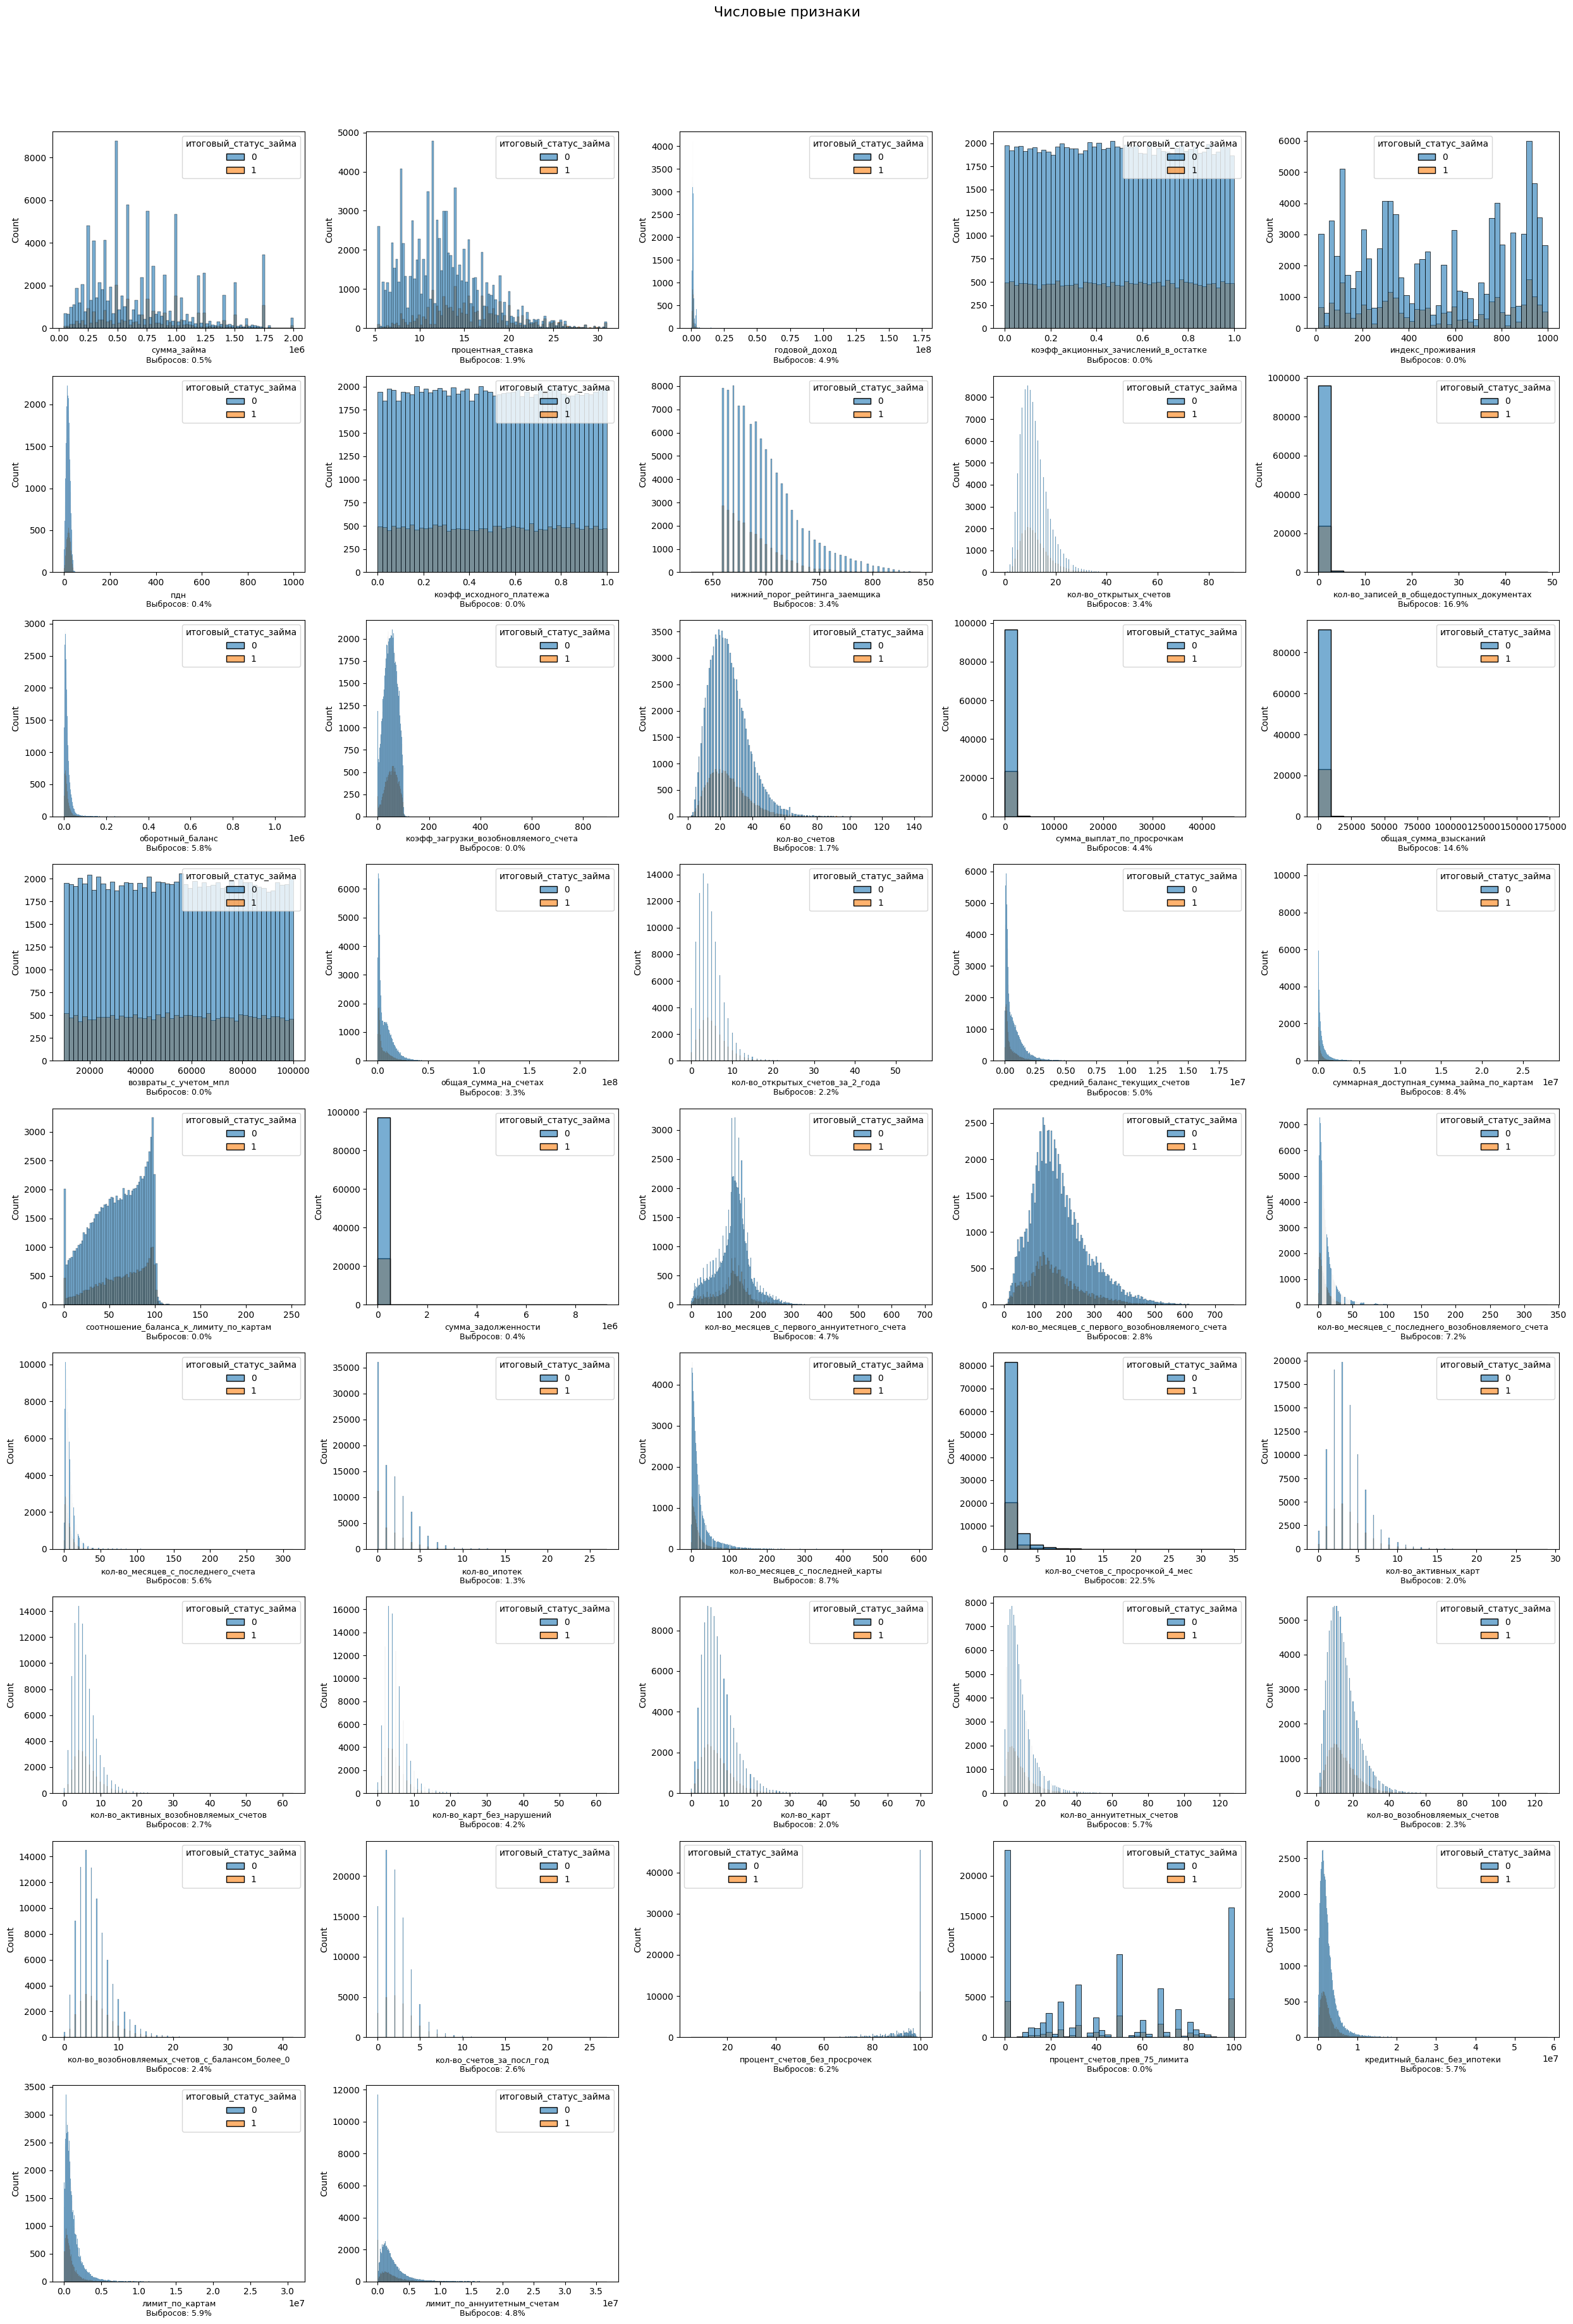

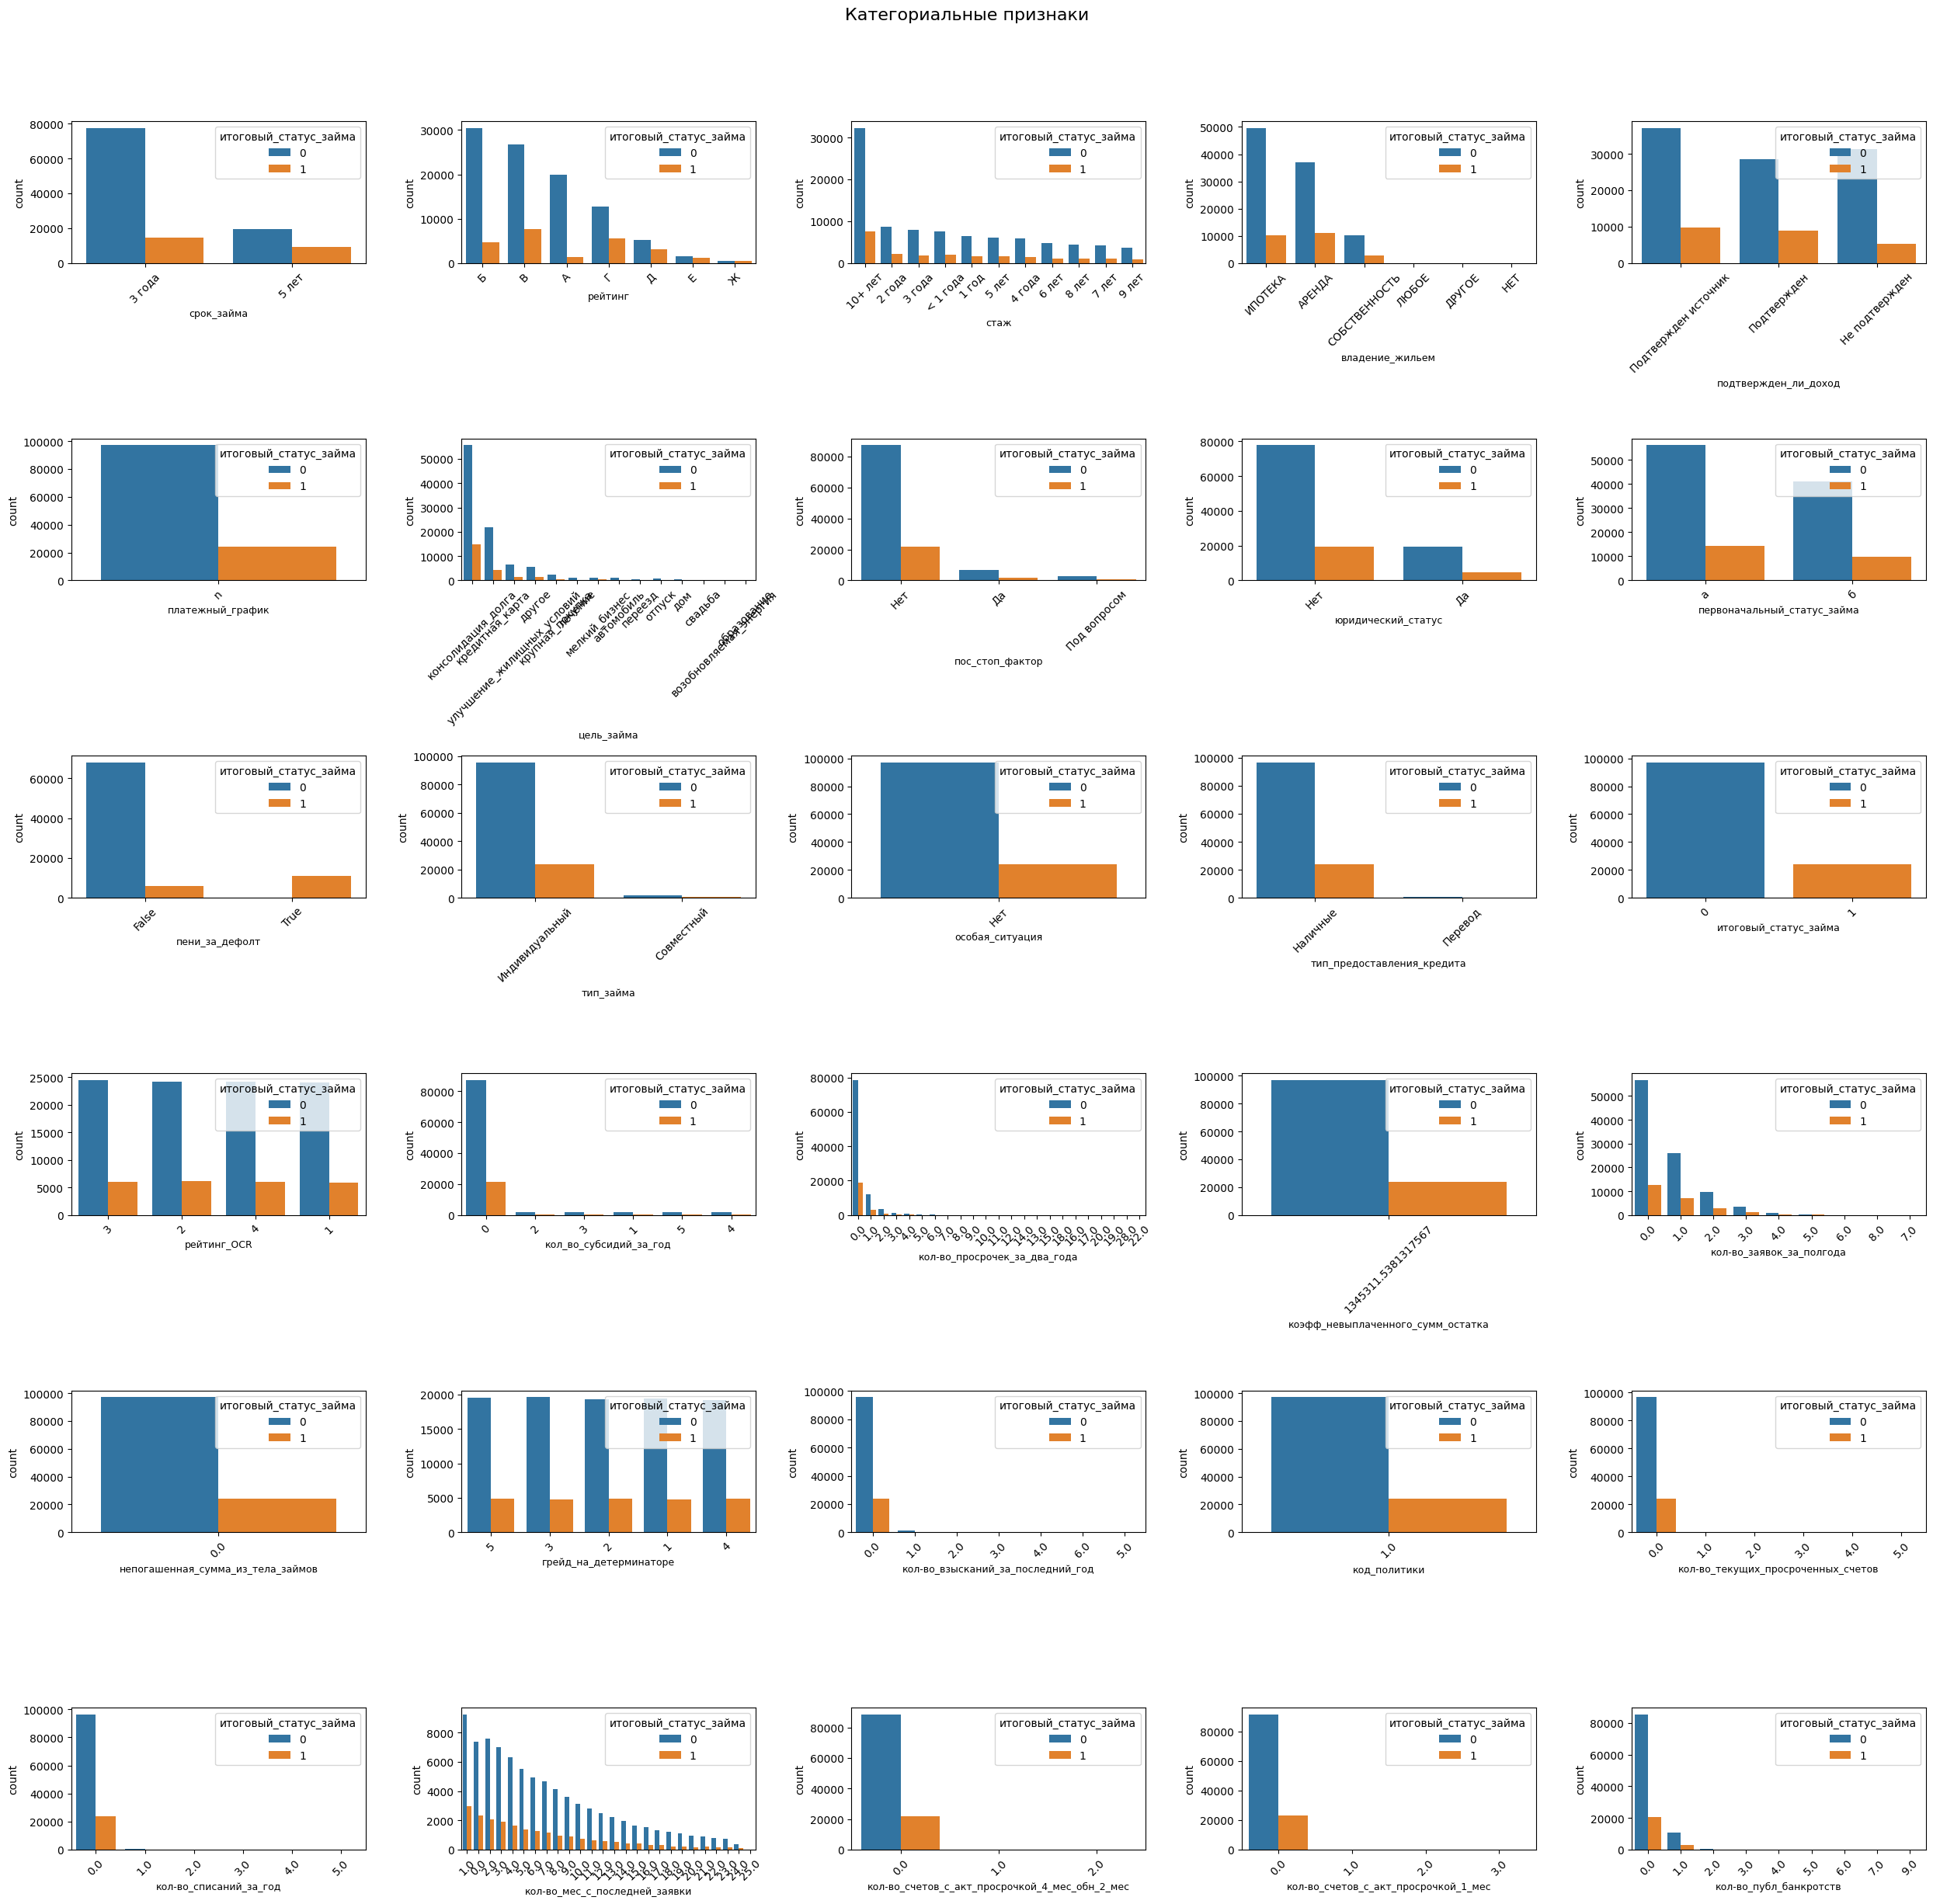

In [17]:
EDA_combined(df_train_EDA, NUM_COLS, CAT_COLS, target='итоговый_статус_займа')

признаки на выброс точно, так как имеют всего одно значение и неинформативный: 'особая_ситуация', 'коэфф_невыплаченного_сумм_остатка', 'непогашенная_сумма_из_тела_займов'

На мой взгляд так же можно выбросить признаки 'рейтинг_OCR', 'грейд_на_детерминаторе' так как для каждой категории доли классов не меняются.

In [18]:
l_rare = ['владение_жильем','цель_займа','кол_во_субсидий_за_год', 'кол-во_просрочек_за_два_года',
     'кол-во_заявок_за_полгода', 'кол-во_взысканий_за_последний_год', 'кол-во_текущих_просроченных_счетов', 
     'кол-во_списаний_за_год', 'кол-во_счетов_с_акт_просрочкой_4_мес_обн_2_мес', 'кол-во_счетов_с_акт_просрочкой_1_мес', 'кол-во_публ_банкротств']

In [19]:
def combine_rare_categories(df: pd.DataFrame, cat_cols: list, min_freq: float = 0.01):
    
    df_copy = df.copy()

    for col in cat_cols:
        if col not in df_copy.columns:
            print(f"Колонка {col} не найдена в DataFrame, пропущена.")
            continue
        
        freq = df_copy[col].value_counts(normalize=True)
        rare_categories = freq[freq < min_freq].index
        df_copy[col] = df_copy[col].apply(lambda x: 'Другое' if x in rare_categories else x)
    
    return df_copy

In [20]:
dfd = combine_rare_categories(df_train_EDA, l_rare, min_freq=0.1)

EDA_combined(dfd, NUM_COLS, CAT_COLS, target='итоговый_статус_займа')

In [21]:
not_informative_features = ['особая_ситуация', 'коэфф_невыплаченного_сумм_остатка', 'непогашенная_сумма_из_тела_займов', 'рейтинг_OCR', 'грейд_на_детерминаторе']

In [23]:
df_train_clear = combine_rare_categories(df_train_clear, l_rare, min_freq=0.1)
df_train_clear = df_train_clear.drop(not_informative_features,axis=1)

In [24]:
CAT_COLS = [i for i in CAT_COLS if i not in  not_informative_features + ['итоговый_статус_займа']]

## 3. Подбор модели

Реализуем пайплан. В зависимости от типа модели, будут использоваться разные способы стандартизации и кодировок признаков.

In [25]:
def build_pipeline(model,type_model, num_features, cat_features):

    if type_model == 'linear':
        numeric_transformer = Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='mean')),
            ('scaler', StandardScaler())
        ])

        categorical_transformer = Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='constant', fill_value='NAN')),
            ('to_str', FunctionTransformer(lambda x: x.astype(str))),
            ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
        ])

        preprocessor = ColumnTransformer(transformers=[
        ('num', numeric_transformer, num_features),
        ('cat', categorical_transformer, cat_features)
        ])

        pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', model)
        ])

        return pipeline
    
    elif type_model == 'tree':
        numeric_transformer = Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='mean')),
        ])

        categorical_transformer = Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='constant', fill_value='NAN')),
            ('to_str', FunctionTransformer(lambda x: x.astype(str))),
            ('encoder', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))
        ])

        preprocessor = ColumnTransformer(transformers=[
        ('num', numeric_transformer, num_features),
        ('cat', categorical_transformer, cat_features)
        ])

        pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', model)
        ])

        return pipeline


Для проверки брал 2 модели: логрег, и кэтбуст.

Для разных моделей объявим функции подбора оптимальных гиперпараметров с кросс валидацией на три фолда с помощью Optuna

In [26]:
def optimize_logreg(X, y, numeric_features, categorical_features, n_trials=50):
    def objective(trial):
       
        params = {
            "penalty": trial.suggest_categorical("penalty", ["l2", None]),
            "C": trial.suggest_float("C", 1e-3, 10.0, log=True),
            "solver": trial.suggest_categorical("solver", ["lbfgs", "saga", "newton-cg"]),
            "max_iter": trial.suggest_int("max_iter", 100, 1000),
            "random_state": RANDOM_STATE
        }

        model = LogisticRegression(**params)

        pipeline = build_pipeline(model, 'linear', numeric_features, categorical_features)

        skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=RANDOM_STATE)
        auc = cross_val_score(pipeline, X, y, cv=skf, scoring='roc_auc', n_jobs=-1)

        return np.mean(auc)

    
    study = optuna.create_study(
        direction="maximize",
        sampler=optuna.samplers.TPESampler(seed=RANDOM_STATE)
    )
    study.optimize(objective, n_trials=n_trials)

    print("Лучшие параметры:", study.best_params)
    print("Лучший ROC-AUC:", study.best_value)

    return study

In [27]:
def optimize_catboost(X, y, num_features, cat_features, n_trials=30, device='CPU'):
    def objective(trial):
        params = {
            "iterations": trial.suggest_int("iterations", 100, 1000),
            "depth": trial.suggest_int("depth", 4, 10),
            "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
            "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1e-2, 10.0, log=True),
            "bootstrap_type": trial.suggest_categorical("bootstrap_type", ["Bayesian", "Bernoulli", "MVS"]),
            "random_strength": trial.suggest_float("random_strength", 1e-2, 10.0, log=True),
            "verbose": 0,
            "task_type": device,
            "random_state": RANDOM_STATE
        }

        
        if params["bootstrap_type"] == "Bayesian":
            params["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0, 10)
        elif params["bootstrap_type"] == "Bernoulli":
            params["subsample"] = trial.suggest_float("subsample", 0.5, 1.0)

        model = CatBoostClassifier(**params)

        pipeline = build_pipeline(model, 'tree', num_features, cat_features)

        skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=RANDOM_STATE)
        auc = cross_val_score(pipeline, X, y, cv=skf, scoring='roc_auc', n_jobs=1)

        return np.mean(auc)

    
    study = optuna.create_study(direction="maximize", sampler=optuna.samplers.TPESampler(seed=RANDOM_STATE))
    study.optimize(objective, n_trials=n_trials)

    print("Лучшие параметры:", study.best_params)
    print("Лучший ROC-AUC:", study.best_value)

    return study

Далее идет блок кода для подбора гиперпараметров. Я его оставлю в виде текстовой ячейки. При необходимости можно преобразовать в код и проверить работоспособность.

train_for_optuna = df_train_clear.sample(frac=best_frac,random_state=RANDOM_STATE)

X_train = train_for_optuna.drop('итоговый_статус_займа',axis=1)
y_train = train_for_optuna['итоговый_статус_займа']

study_LogReg = optimize_logreg(X_train, y_train, NUM_COLS, CAT_COLS, n_trials=20)
study_CatBoost = optimize_catboost(X_train, y_train, NUM_COLS, CAT_COLS, n_trials=20, device='GPU')

Наилучшие параметры для кэтбуста я заранее сохранил в json-файл и далее использую его.

Теперь посмотрим более детально на графики и метрики классификации.

In [28]:
X_train,X_valid,y_train,y_valid = train_test_split(df_train_clear.drop('итоговый_статус_займа',axis=1), 
    df_train_clear['итоговый_статус_займа'], test_size=0.2, random_state=RANDOM_STATE, stratify=df_train_clear['итоговый_статус_займа'])

Необходимо убедится, что наша модель дает метрику лучше , чем dummy-модель

In [38]:
dummy_model = DummyClassifier(strategy="uniform", random_state=RANDOM_STATE)
dummy_model.fit(X_train, y_train)

y_pred_proba = dummy_model.predict_proba(X_valid)[:, 1]

roc_auc = roc_auc_score(y_valid, y_pred_proba)
print(f"ROC AUC дамми-модели: {roc_auc:.4f}")

ROC AUC дамми-модели: 0.5000


In [29]:
pipeline_for_valid = build_pipeline(CatBoostClassifier(**CATBOOST_PARAMS), 'tree', NUM_COLS, CAT_COLS)

In [36]:
def valid(pipl, trashhold=0.5):
    pipeline_for_valid = pipl
    pipeline_for_valid.fit(X_train, y_train)
    y_proba = pipeline_for_valid.predict_proba(X_valid)[:, 1]
    y = np.array(list(map(lambda x: 0 if x < trashhold else 1, y_proba)))
    ROC_AUC = roc_auc_score(y_valid, y_proba)

    fig, axes = plt.subplots(1, 3, figsize=(17, 5))

    precision, recall, thresholds = precision_recall_curve(y_valid, y)
    pr_auc = auc(recall, precision)

    ConfusionMatrixDisplay.from_predictions(
        y_valid, y,
        ax=axes[0],
        colorbar=False,
    )

    RocCurveDisplay.from_predictions(
        y_valid, y_proba,
        ax=axes[1],
        color='orange',
    )
    axes[1].plot([0, 1], [0, 1], color='navy', linestyle='--')
    axes[1].set_ylim(0, 1.01)
    axes[1].set_xlim(-0.01, 1)

    axes[2].plot(recall, precision, marker='.', label=f'PR Curve (AUC={pr_auc:.2f})', color='b')
    axes[2].set_title('Precision-Recall Curve')
    axes[2].set_xlabel('Recall')
    axes[2].set_ylabel('Precision')
    axes[2].legend()
    axes[2].grid()

    plt.show()

    print(classification_report(y_valid, y))

    cat_boost_model = pipeline_for_valid.named_steps['classifier']
    X_train_transformed = pipeline_for_valid.named_steps['preprocessor'].transform(X_train)

    explainer = shap.TreeExplainer(cat_boost_model)
    shap_values = explainer.shap_values(X_train_transformed)
    expected_value = explainer.expected_value

    plt.figure(figsize=(12, 8))  # увеличенный размер для лучшей читаемости
    plt.title('Вклад каждого признака в формирование предсказания')
    plt.ylabel('Признаки')

    shap.summary_plot(
        shap_values=shap_values,
        features=X_train,
        max_display=20,       # показываем топ-20 признаков
        color_bar=False,
    )

    plt.show()

0:	learn: 0.6352495	total: 9.06ms	remaining: 4.88s
1:	learn: 0.5865044	total: 17.4ms	remaining: 4.67s
2:	learn: 0.5465029	total: 25.7ms	remaining: 4.58s
3:	learn: 0.5125148	total: 34.2ms	remaining: 4.58s
4:	learn: 0.4843919	total: 42.7ms	remaining: 4.56s
5:	learn: 0.4600298	total: 51.4ms	remaining: 4.56s
6:	learn: 0.4394103	total: 59.9ms	remaining: 4.55s
7:	learn: 0.4216790	total: 68.2ms	remaining: 4.52s
8:	learn: 0.4064411	total: 76.5ms	remaining: 4.5s
9:	learn: 0.3930894	total: 84.6ms	remaining: 4.47s
10:	learn: 0.3815813	total: 92.7ms	remaining: 4.45s
11:	learn: 0.3711194	total: 101ms	remaining: 4.43s
12:	learn: 0.3619335	total: 110ms	remaining: 4.44s
13:	learn: 0.3542842	total: 118ms	remaining: 4.41s
14:	learn: 0.3472680	total: 126ms	remaining: 4.41s
15:	learn: 0.3409941	total: 134ms	remaining: 4.39s
16:	learn: 0.3356997	total: 142ms	remaining: 4.37s
17:	learn: 0.3306963	total: 150ms	remaining: 4.35s
18:	learn: 0.3264861	total: 159ms	remaining: 4.34s
19:	learn: 0.3229285	total: 166

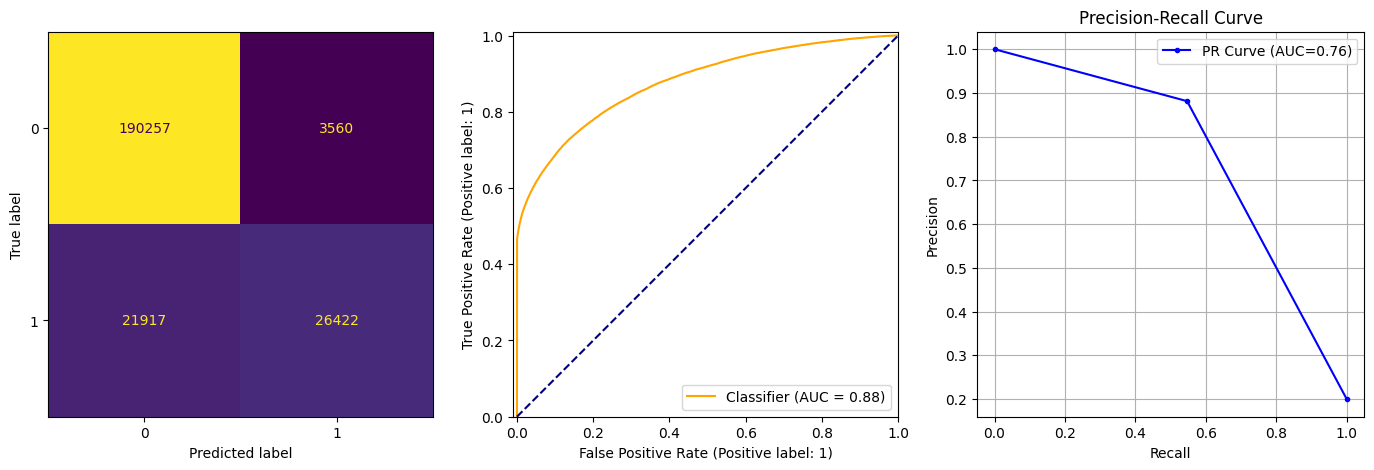

              precision    recall  f1-score   support

           0       0.90      0.98      0.94    193817
           1       0.88      0.55      0.67     48339

    accuracy                           0.89    242156
   macro avg       0.89      0.76      0.81    242156
weighted avg       0.89      0.89      0.88    242156



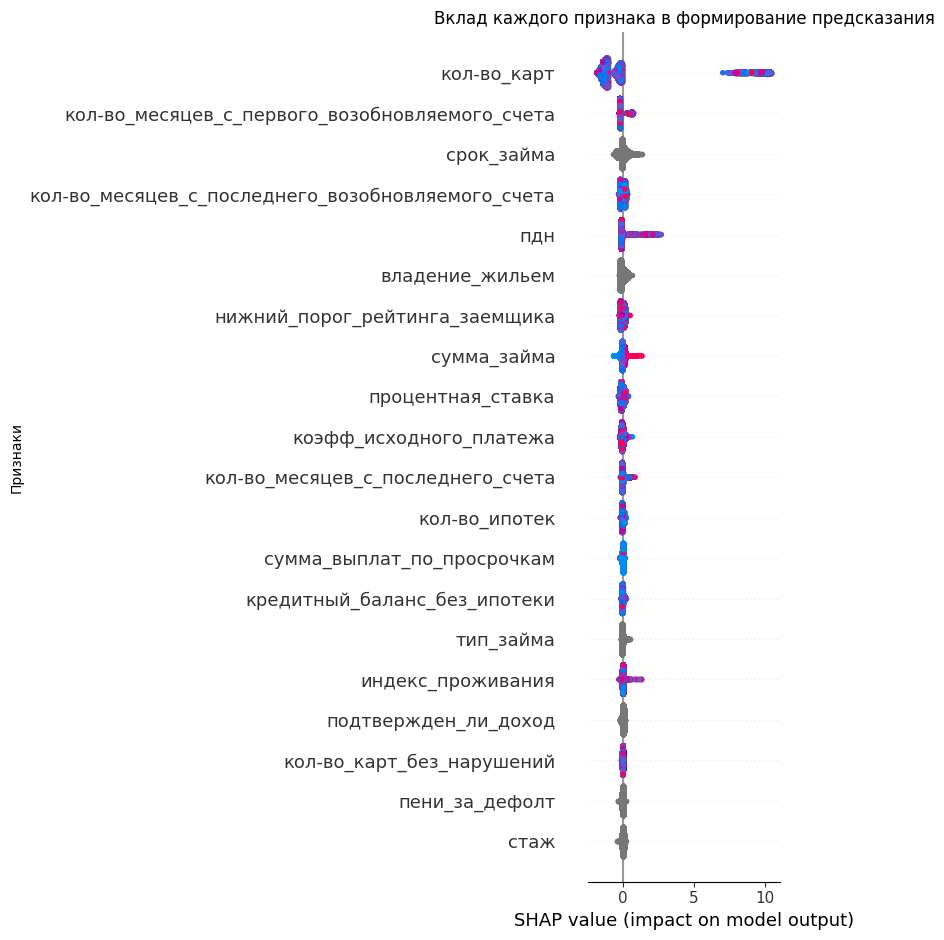

In [37]:
valid(pipeline_for_valid,trashhold=0.4)

Из увиденного выше можно сделать следующие выводы:

1. Модель отлично находит нулевой класс, и только половину единиц. (что в целом лучше , чем ничего, ведь в нашем случае мы отсекаем половину неплательщиков , не трогая при этом благонадежных заемщимков)
2. Целевая метрика на том же уровне, что и при кросс-валидации
3. Значение целевой метрики значительно выше dummy-модели (0.5 < 0.8)

In [32]:
df_train_final = df_train_clear.sample(frac=best_frac,random_state=RANDOM_STATE)
X_train = df_train_final.drop('итоговый_статус_займа',axis=1)
y_train = df_train_final['итоговый_статус_займа']

Тестирование модели

In [34]:
df_test = combine_rare_categories(df_test, l_rare, min_freq=0.1)
df_test = df_test.drop(not_informative_features,axis=1)

X_test = df_test[NUM_COLS + CAT_COLS]
pipeline_for_test = build_pipeline(CatBoostClassifier(**CATBOOST_PARAMS), 'tree', NUM_COLS, CAT_COLS)
pipeline_for_test.fit(X_train,y_train)
y_proba =  pipeline_for_test.predict_proba(X_test)[:, 1]


0:	learn: 0.6352495	total: 8.39ms	remaining: 4.51s
1:	learn: 0.5865044	total: 16.1ms	remaining: 4.32s
2:	learn: 0.5465029	total: 23.9ms	remaining: 4.27s
3:	learn: 0.5125148	total: 31.3ms	remaining: 4.19s
4:	learn: 0.4843919	total: 38.9ms	remaining: 4.15s
5:	learn: 0.4600298	total: 46.6ms	remaining: 4.14s
6:	learn: 0.4394103	total: 54.4ms	remaining: 4.13s
7:	learn: 0.4216790	total: 62ms	remaining: 4.12s
8:	learn: 0.4064411	total: 69.7ms	remaining: 4.11s
9:	learn: 0.3930894	total: 77ms	remaining: 4.07s
10:	learn: 0.3815813	total: 84.3ms	remaining: 4.05s
11:	learn: 0.3711194	total: 91.7ms	remaining: 4.03s
12:	learn: 0.3619335	total: 99.5ms	remaining: 4.02s
13:	learn: 0.3542842	total: 107ms	remaining: 4.01s
14:	learn: 0.3472680	total: 114ms	remaining: 3.99s
15:	learn: 0.3409941	total: 122ms	remaining: 3.98s
16:	learn: 0.3356997	total: 129ms	remaining: 3.96s
17:	learn: 0.3306963	total: 136ms	remaining: 3.93s
18:	learn: 0.3264861	total: 143ms	remaining: 3.91s
19:	learn: 0.3229285	total: 150m

In [ ]:
#submission['proba'] = y_proba
#submission.to_csv('submission.csv', index=False)